In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import sys, os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from Resources.Model import Model_v4, Model_v5, Model_v6, Model_v7, Model_v8, Model_v9, Model_v10, Model_v11
from Resources.Game import *


In [3]:
# Get number of training batches
training_data = os.listdir('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8')
i_training_data = 0
while 'inputs_'+str(i_training_data + 1) in training_data:
    i_training_data += 1
n_training_data = i_training_data

In [21]:
n_training_data = 1000

### Model Architecture Comparison

In [8]:
error_hist_tot_models = []

lr0 = 1.5e-3
a = 250
n_batches = 1
n_replay = 0    # replay helps, but takes too long here

for model_ind in [4, 5, 6, 7]:

    print(' -- model: ', model_ind)

    if model_ind == 4:
        model = Model_v4()
    if model_ind == 5:
        model = Model_v5()
    if model_ind == 6:
        model = Model_v6()
    if model_ind == 7:
        model = Model_v7()
    if model_ind == 8:
        model = Model_v8()
    criterion = nn.MSELoss()

    pars = [i for i in model.parameters()]
    print('number of parameters: ', sum(i.numel() for i in model.parameters()))

    error_hist_curr_models = []

    for batch in range(1, 1500):#n_training_data + 1):

        # load all new data
        inputs = []
        labels = []
        for index in range(batch, batch + 1):
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)


        ''' # -- REPLAY --
        # get error of new data (without backprop)
        out = model(inputs_tens)
        out = out.view(out.shape[0])
        loss = criterion(out, labels_tens)
        error_hist_curr_models.append(loss.item())
        
        # load additional older data to replay
        if batch > 5:
            # samples from exp distribution, more recent -> more likely
            decay_rate = 0.02
            prob =  np.exp(-decay_rate * np.arange(batch)) 
            prob = prob/sum(prob)
            num_samples = n_replay
            samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
            for index in samples:
                inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
                labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)
        '''

        if batch % 100 == 0:
            print('model: ', model_ind, 'training batch ', batch)

        t0 = time.time()

        # training step
        model.train()

        optimizer = optim.Adam(model.parameters(), lr=lr0 * a / (a + batch), weight_decay=0)

        # shuffle data and make mini batches
        indices = torch.randperm(len(inputs_tens))
        inputs_tens = inputs_tens[indices]
        labels_tens = labels_tens[indices]

        batch_size = len(inputs_tens) // n_batches

        inputs_loader = inputs_tens.split(batch_size)
        labels_loader = labels_tens.split(batch_size)

        for inputs, labels in zip(inputs_loader, labels_loader):

            out = model(inputs)
            out = out.view(out.shape[0])
            loss = criterion(out, labels)
            
            error_hist_curr_models.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    error_hist_tot_models.append(error_hist_curr_models)

 -- model:  4
number of parameters:  30677
model:  4 training batch  100
model:  4 training batch  200
model:  4 training batch  300
model:  4 training batch  400
model:  4 training batch  500
model:  4 training batch  600
model:  4 training batch  700
model:  4 training batch  800
model:  4 training batch  900
model:  4 training batch  1000
model:  4 training batch  1100
model:  4 training batch  1200
model:  4 training batch  1300
model:  4 training batch  1400
 -- model:  5
number of parameters:  221345
model:  5 training batch  100
model:  5 training batch  200
model:  5 training batch  300
model:  5 training batch  400
model:  5 training batch  500
model:  5 training batch  600
model:  5 training batch  700
model:  5 training batch  800
model:  5 training batch  900
model:  5 training batch  1000
model:  5 training batch  1100
model:  5 training batch  1200
model:  5 training batch  1300
model:  5 training batch  1400
 -- model:  6
number of parameters:  83233
model:  6 training b

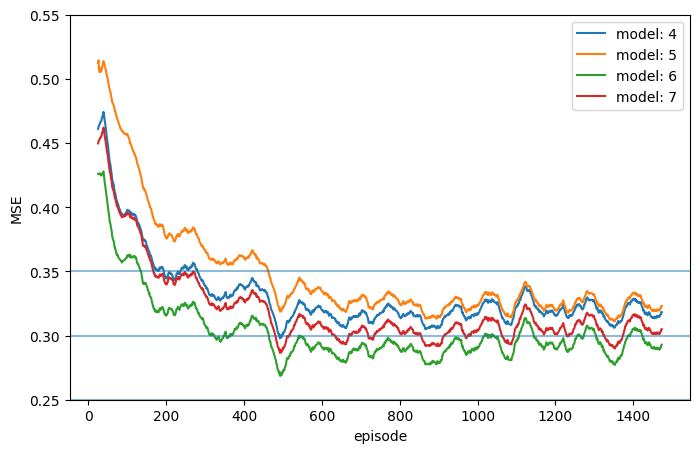

In [9]:
models = [4, 5, 6, 7, 8]

plt.figure(figsize=(8, 5))
for e, error_hist in enumerate(error_hist_tot_models):
    plt.plot(range(25, len(error_hist) - 25), [np.mean(error_hist[i:i+50]) for i in range(len(error_hist) - 50)], label='model: '+str(models[e]))

plt.legend()
plt.ylim([0.25, 0.55])
plt.axhline(0.35, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.30, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.25, xmin=0, xmax=1000, alpha=0.5)
plt.xlabel('episode')
plt.ylabel('MSE')
plt.show()

In [ ]:
# Best model: 6 (fully connected one, no convs)
# meets limitation quickly
# model 5: big but pooling -> bad -> dont use pooling
# model 4: very small

# Best model apart from 6: 8
# converges slowly, but best long term behavior

# Next test: is even bigger model even better?
# model 9: wider model
# model 10: deeper model
# model 11: wider as well as deeper

error_hist_tot_models = []

lr0 = 1.5e-3
a = 250
n_batches = 1
n_replay = 0    # replay helps, but takes too long here

for model_ind in [4, 5, 6, 7]:

    print(' -- model: ', model_ind)

    if model_ind == 4:
        model = Model_v4()
    if model_ind == 5:
        model = Model_v5()
    if model_ind == 6:
        model = Model_v6()
    if model_ind == 7:
        model = Model_v7()
    if model_ind == 8:
        model = Model_v8()
    criterion = nn.MSELoss()

    pars = [i for i in model.parameters()]
    print('number of parameters: ', sum(i.numel() for i in model.parameters()))

    error_hist_curr_models = []

    for batch in range(1, 1500):#n_training_data + 1):

        # load all new data
        inputs = []
        labels = []
        for index in range(batch, batch + 1):
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)


        ''' # -- REPLAY --
        # get error of new data (without backprop)
        out = model(inputs_tens)
        out = out.view(out.shape[0])
        loss = criterion(out, labels_tens)
        error_hist_curr_models.append(loss.item())
        
        # load additional older data to replay
        if batch > 5:
            # samples from exp distribution, more recent -> more likely
            decay_rate = 0.02
            prob =  np.exp(-decay_rate * np.arange(batch)) 
            prob = prob/sum(prob)
            num_samples = n_replay
            samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
            for index in samples:
                inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
                labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)
        '''

        if batch % 100 == 0:
            print('model: ', model_ind, 'training batch ', batch)

        t0 = time.time()

        # training step
        model.train()

        optimizer = optim.Adam(model.parameters(), lr=lr0 * a / (a + batch), weight_decay=0)

        # shuffle data and make mini batches
        indices = torch.randperm(len(inputs_tens))
        inputs_tens = inputs_tens[indices]
        labels_tens = labels_tens[indices]

        batch_size = len(inputs_tens) // n_batches

        inputs_loader = inputs_tens.split(batch_size)
        labels_loader = labels_tens.split(batch_size)

        for inputs, labels in zip(inputs_loader, labels_loader):

            out = model(inputs)
            out = out.view(out.shape[0])
            loss = criterion(out, labels)
            
            error_hist_curr_models.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    error_hist_tot_models.append(error_hist_curr_models)

In [ ]:
models = [4, 5, 6, 7, 8]

plt.figure(figsize=(8, 5))
for e, error_hist in enumerate(error_hist_tot_models):
    plt.plot(range(25, len(error_hist) - 25), [np.mean(error_hist[i:i+50]) for i in range(len(error_hist) - 50)], label='model: '+str(models[e]))

plt.legend()
plt.ylim([0.25, 0.55])
plt.axhline(0.35, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.30, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.25, xmin=0, xmax=1000, alpha=0.5)
plt.xlabel('episode')
plt.ylabel('MSE')
plt.show()

In [5]:
error_hist_tot_models2 = []

lr0 = 1.5e-3
a = 250
n_batches = 1
n_replay = 0    # replay helps, but takes too long here

for model_ind in [8, 9, 10, 11]:

    print(' -- model: ', model_ind)

    if model_ind == 8:
        model = Model_v8()
    if model_ind == 9:
        model = Model_v9()
    if model_ind == 10:
        model = Model_v10()
    if model_ind == 11:
        model = Model_v11()
    criterion = nn.MSELoss()

    pars = [i for i in model.parameters()]
    print('number of parameters: ', sum(i.numel() for i in model.parameters()))

    error_hist_curr_models2 = []

    for batch in range(1, 1500):#n_training_data + 1):

        # load all new data
        inputs = []
        labels = []
        for index in range(batch, batch + 1):
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)


        ''' # -- REPLAY --
        # get error of new data (without backprop)
        out = model(inputs_tens)
        out = out.view(out.shape[0])
        loss = criterion(out, labels_tens)
        error_hist_curr_models.append(loss.item())
        
        # load additional older data to replay
        if batch > 5:
            # samples from exp distribution, more recent -> more likely
            decay_rate = 0.02
            prob =  np.exp(-decay_rate * np.arange(batch)) 
            prob = prob/sum(prob)
            num_samples = n_replay
            samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
            for index in samples:
                inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
                labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)
        '''

        if batch % 100 == 0:
            print('model: ', model_ind, 'training batch ', batch)

        t0 = time.time()

        # training step
        model.train()

        optimizer = optim.Adam(model.parameters(), lr=lr0 * a / (a + batch), weight_decay=0)

        # shuffle data and make mini batches
        indices = torch.randperm(len(inputs_tens))
        inputs_tens = inputs_tens[indices]
        labels_tens = labels_tens[indices]

        batch_size = len(inputs_tens) // n_batches

        inputs_loader = inputs_tens.split(batch_size)
        labels_loader = labels_tens.split(batch_size)

        for inputs, labels in zip(inputs_loader, labels_loader):

            out = model(inputs)
            out = out.view(out.shape[0])
            loss = criterion(out, labels)
            
            error_hist_curr_models2.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    error_hist_tot_models2.append(error_hist_curr_models2)

 -- model:  8
number of parameters:  2188757
model:  8 training batch  100
model:  8 training batch  200
model:  8 training batch  300
model:  8 training batch  400
model:  8 training batch  500
model:  8 training batch  600
model:  8 training batch  700
model:  8 training batch  800
model:  8 training batch  900
model:  8 training batch  1000
model:  8 training batch  1100
model:  8 training batch  1200
model:  8 training batch  1300
model:  8 training batch  1400
 -- model:  9
number of parameters:  18776957
model:  9 training batch  100
model:  9 training batch  200
model:  9 training batch  300
model:  9 training batch  400
model:  9 training batch  500
model:  9 training batch  600
model:  9 training batch  700
model:  9 training batch  800
model:  9 training batch  900
model:  9 training batch  1000
model:  9 training batch  1100
model:  9 training batch  1200
model:  9 training batch  1300
model:  9 training batch  1400
 -- model:  10
number of parameters:  2598997
model:  10 tr

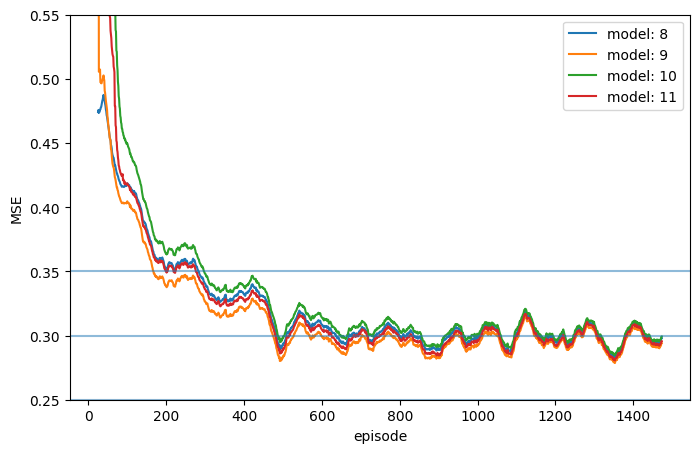

In [6]:
models = [8, 9, 10, 11]

plt.figure(figsize=(8, 5))
for e, error_hist in enumerate(error_hist_tot_models2):
    plt.plot(range(25, len(error_hist) - 25), [np.mean(error_hist[i:i+50]) for i in range(len(error_hist) - 50)], label='model: '+str(models[e]))

plt.legend()
plt.ylim([0.25, 0.55])
plt.axhline(0.35, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.30, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.25, xmin=0, xmax=1000, alpha=0.5)
plt.xlabel('episode')
plt.ylabel('MSE')
plt.show()

In [4]:
for model_ind in [8, 9, 10, 11]:

    print(' -- model: ', model_ind)

    if model_ind == 8:
        model = Model_v8()
    if model_ind == 9:
        model = Model_v9()
    if model_ind == 10:
        model = Model_v10()
    if model_ind == 11:
        model = Model_v11()
    criterion = nn.MSELoss()

    pars = [i for i in model.parameters()]
    print('number of parameters: ', sum(i.numel() for i in model.parameters()))

 -- model:  8
number of parameters:  2188757
 -- model:  9
number of parameters:  18776957
 -- model:  10
number of parameters:  2598997
 -- model:  11
number of parameters:  22465277


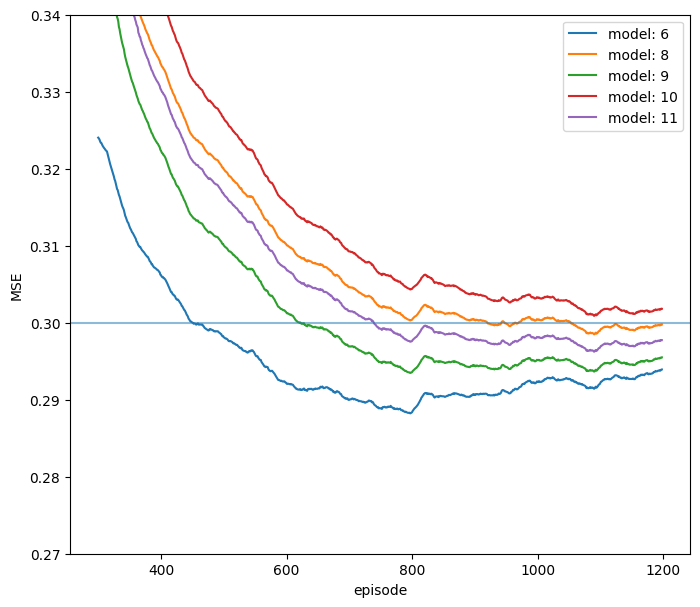

In [22]:
av_window = 300

models = [4, 5, 6, 7, 8]

plt.figure(figsize=(8, 7))
for e, error_hist in enumerate(error_hist_tot_models):
    if models[e] in [4, 5, 7]:
        continue
    plt.plot(range(av_window, len(error_hist) - av_window), [np.mean(error_hist[i:i+av_window*2]) for i in range(len(error_hist) - av_window*2)], label='model: '+str(models[e]))

models2 = [8, 9, 10, 11]
for e, error_hist in enumerate(error_hist_tot_models2):
    plt.plot(range(av_window, len(error_hist) - av_window), [np.mean(error_hist[i:i+av_window*2]) for i in range(len(error_hist) - av_window*2)], label='model: '+str(models2[e]))

plt.legend()
plt.ylim([0.27, 0.34])
plt.axhline(0.35, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.30, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.25, xmin=0, xmax=1000, alpha=0.5)
plt.xlabel('episode')
plt.ylabel('MSE')
plt.show()

In [ ]:
# This metric benefits the case without replay

In [24]:
error_hist_tot_models3 = []

lr0 = 1.5e-3
a = 250
n_batches = 10
n_replay = 5        # replay helps, but takes too long here
weight_decay = 1e-7

for model_ind in [6, 8, 9, 10, 11]:

    print(' -- model: ', model_ind)

    if model_ind == 6:
        model = Model_v6()
    if model_ind == 8:
        model = Model_v8()
    if model_ind == 9:
        model = Model_v9()
    if model_ind == 10:
        model = Model_v10()
    if model_ind == 11:
        model = Model_v11()

    criterion = nn.MSELoss()

    pars = [i for i in model.parameters()]
    print('number of parameters: ', sum(i.numel() for i in model.parameters()))

    error_hist_curr_models3 = []

    for batch in range(1, 1780):#n_training_data + 1):

        # load all new data
        inputs = []
        labels = []
        for index in range(batch, batch + 1):
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)

        # -- REPLAY --
        # get error of new data (without backprop)
        out = model(inputs_tens)
        out = out.view(out.shape[0])
        loss = criterion(out, labels_tens)
        error_hist_curr_models3.append(loss.item())
        
        # load additional older data to replay
        if batch > 5:
            # samples from exp distribution, more recent -> more likely
            decay_rate = 0.02
            prob =  np.exp(-decay_rate * np.arange(batch)) 
            prob = prob/sum(prob)
            num_samples = n_replay
            samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
            for index in samples:
                inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
                labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)

        if batch % 100 == 0:
            print('model: ', model_ind, 'training batch ', batch)

        t0 = time.time()

        # training step
        model.train()

        optimizer = optim.Adam(model.parameters(), lr=lr0 * a / (a + batch), weight_decay=weight_decay)

        # shuffle data and make mini batches
        indices = torch.randperm(len(inputs_tens))
        inputs_tens = inputs_tens[indices]
        labels_tens = labels_tens[indices]

        batch_size = len(inputs_tens) // n_batches

        inputs_loader = inputs_tens.split(batch_size)
        labels_loader = labels_tens.split(batch_size)

        for inputs, labels in zip(inputs_loader, labels_loader):

            out = model(inputs)
            out = out.view(out.shape[0])
            loss = criterion(out, labels)
            
            # error_hist_curr_models3.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    error_hist_tot_models3.append(error_hist_curr_models3)

 -- model:  8
number of parameters:  2188757
model:  8 training batch  100


KeyboardInterrupt: 

### Visualise Individual Training Labels / Model Outputs

In [38]:
name = 'v8_3' # name of used run

model = Model_v8()
model_saves = os.listdir('../Monte Carlo/Model Saves MC {}'.format(name))
if len(model_saves) > 0:
    newest_model = max(int(i[6:-8]) for i in model_saves)
    latest_batch_index = newest_model
    model.load_state_dict(torch.load('../Monte Carlo/Model Saves MC {}/model_{}_batches'.format(name, newest_model)))
criterion = nn.MSELoss()

inputs = []
labels = []
for index in range(latest_batch_index, latest_batch_index + 1):
    inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/inputs_{}'.format(name, index)))
    labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/labels_{}'.format(name, index)))

inputs_tens = torch.cat(inputs).float() # bool -> float
labels_tens = torch.cat(labels)

# # samples from exp distribution, more recent -> more likely
# decay_rate = 0.02
# prob =  np.exp(-decay_rate * np.arange(latest_batch_index)) 
# prob = prob/sum(prob)
# num_samples = n_replay
# samples = np.random.choice(np.arange(latest_batch_index, 0, -1), size=num_samples, p=prob)
# for index in samples:
#     inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/inputs_{}'.format(name, index)))
#     labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves {}/labels_{}'.format(name, index)))

# inputs_tens = torch.cat(inputs).float() # bool -> float
# labels_tens = torch.cat(labels)   

out = model(inputs_tens)
out = out.view(out.shape[0])

zero_out = torch.zeros_like(labels_tens)

loss = criterion(out, labels_tens)
loss_trivial = criterion(zero_out, labels_tens)

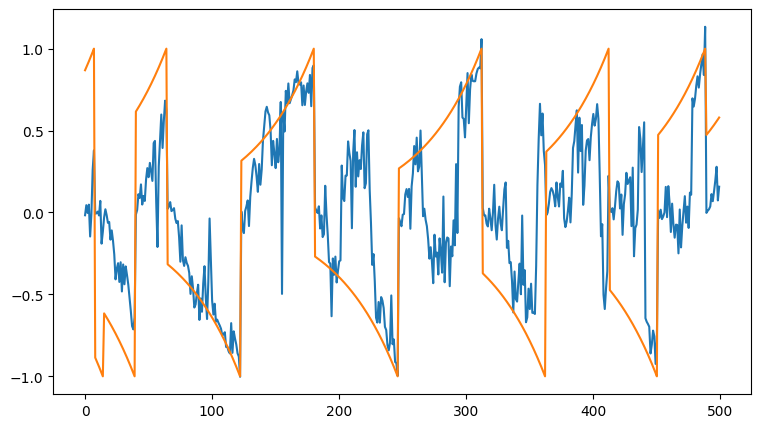

In [39]:
plt.figure(figsize=(9, 5))
plt.plot(out.detach().numpy()[0:500])
plt.plot(labels_tens.detach().numpy()[0:500])
plt.show()